MBTI Type Dataset Fetch via KaggleHub

In [3]:
import kagglehub
import pandas as pd
import re
from pathlib import Path

In [4]:
path = kagglehub.dataset_download("datasnaek/mbti-type")
path = Path(path)

Dataset Preprocessing

In [5]:
print(list(path.rglob("*.csv")))

[PosixPath('/kaggle/input/mbti-type/mbti_1.csv')]


In [6]:
df = pd.read_csv("/kaggle/input/mbti-type/mbti_1.csv")
print(df.head())
print(df['type'].value_counts())

   type                                              posts
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1  ENTP  'I'm finding the lack of me in these posts ver...
2  INTP  'Good one  _____   https://www.youtube.com/wat...
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...
4  ENTJ  'You're fired.|||That's another silly misconce...
type
INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: count, dtype: int64


In [7]:
def clean_step1(text):
    text = text.replace("|||", " ")
    text = text.replace("\n", " ").replace("\t", " ").strip()
    return text

df['clean_posts'] = df['posts'].apply(clean_step1)

In [8]:
def clean_step2(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

df['clean_posts'] = df['clean_posts'].apply(clean_step2)

In [9]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def clean_step3(text):
    words = text.split()
    filtered = [word for word in words if word not in stop_words]
    return ' '.join(filtered)

df['clean_posts'] = df['clean_posts'].apply(clean_step3)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def clean_step4(text):
    words = text.split()
    lemmatized = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized)

df['clean_posts'] = df['clean_posts'].apply(clean_step4)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
print(df[['type', 'clean_posts']].head())

   type                                        clean_posts
0  INFJ  enfp intj moment sportscenter top ten play pra...
1  ENTP  im finding lack post alarming sex boring posit...
2  INTP  good one course say know thats blessing curse ...
3  INTJ  dear intp enjoyed conversation day esoteric ga...
4  ENTJ  youre fired thats another silly misconception ...


Feature Extrction

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = tfidf.fit_transform(df['clean_posts'])

Label Encoding

In [13]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(df['type'])
print(le.classes_)
print(y[:10])

['ENFJ' 'ENFP' 'ENTJ' 'ENTP' 'ESFJ' 'ESFP' 'ESTJ' 'ESTP' 'INFJ' 'INFP'
 'INTJ' 'INTP' 'ISFJ' 'ISFP' 'ISTJ' 'ISTP']
[ 8  3 11 10  2 10  8 10  8 11]


Train / Test Split

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(6940, 5000) (1735, 5000)
(6940,) (1735,)


Model 1 - Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

lr_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

print("=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

=== Logistic Regression ===
Accuracy: 0.6749279538904899
Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.68      0.56        38
           1       0.66      0.64      0.65       135
           2       0.46      0.65      0.54        46
           3       0.61      0.63      0.62       137
           4       0.27      0.33      0.30         9
           5       0.00      0.00      0.00        10
           6       0.57      0.50      0.53         8
           7       0.38      0.56      0.45        18
           8       0.81      0.67      0.73       294
           9       0.77      0.71      0.74       366
          10       0.68      0.65      0.66       218
          11       0.75      0.76      0.75       261
          12       0.61      0.70      0.65        33
          13       0.49      0.59      0.54        54
          14       0.49      0.56      0.52        41
          15       0.61      0.76      0.68        67


Model 2 - Linear SVC

In [16]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score

svc_model = LinearSVC(random_state=42)
svc_model.fit(X_train, y_train)

y_pred_svc = svc_model.predict(X_test)

print("=== Linear SVC ===")
print("Accuracy:", accuracy_score(y_test, y_pred_svc))
print("Classification Report:\n", classification_report(y_test, y_pred_svc))

=== Linear SVC ===
Accuracy: 0.6374639769452449
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.37      0.46        38
           1       0.65      0.57      0.61       135
           2       0.63      0.41      0.50        46
           3       0.57      0.53      0.55       137
           4       1.00      0.33      0.50         9
           5       0.00      0.00      0.00        10
           6       1.00      0.25      0.40         8
           7       0.58      0.39      0.47        18
           8       0.65      0.69      0.67       294
           9       0.64      0.76      0.69       366
          10       0.59      0.62      0.60       218
          11       0.68      0.78      0.73       261
          12       0.71      0.45      0.56        33
          13       0.63      0.44      0.52        54
          14       0.50      0.32      0.39        41
          15       0.68      0.58      0.63        67

    accu

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model 3 - Random Forest Classifier

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("=== Random Forest Classifier ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

=== Random Forest Classifier ===
Accuracy: 0.577521613832853
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.03      0.05        38
           1       0.79      0.47      0.59       135
           2       1.00      0.07      0.12        46
           3       0.67      0.44      0.53       137
           4       0.00      0.00      0.00         9
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00        18
           8       0.54      0.69      0.61       294
           9       0.51      0.87      0.64       366
          10       0.66      0.58      0.62       218
          11       0.61      0.78      0.68       261
          12       1.00      0.03      0.06        33
          13       1.00      0.04      0.07        54
          14       0.50      0.02      0.05        41
          15       0.75      0.27      0.40       

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Hyperparameter Tuning (with model 1)

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear', 'saga'],
    'class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

print("=== Tuned Logistic Regression ===")
print("Best Params:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("Classification Report:\n", classification_report(y_test, y_pred_best))


Fitting 5 folds for each of 16 candidates, totalling 80 fits
=== Tuned Logistic Regression ===
Best Params: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.6899135446685879
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.68      0.63        38
           1       0.68      0.63      0.65       135
           2       0.53      0.65      0.58        46
           3       0.62      0.62      0.62       137
           4       0.27      0.33      0.30         9
           5       0.00      0.00      0.00        10
           6       0.67      0.50      0.57         8
           7       0.45      0.56      0.50        18
           8       0.81      0.66      0.73       294
           9       0.73      0.77      0.75       366
          10       0.69      0.64      0.66       218
          11       0.75      0.80      0.78       261
          12       0.66      0.70      0.68        33
     

Visualization

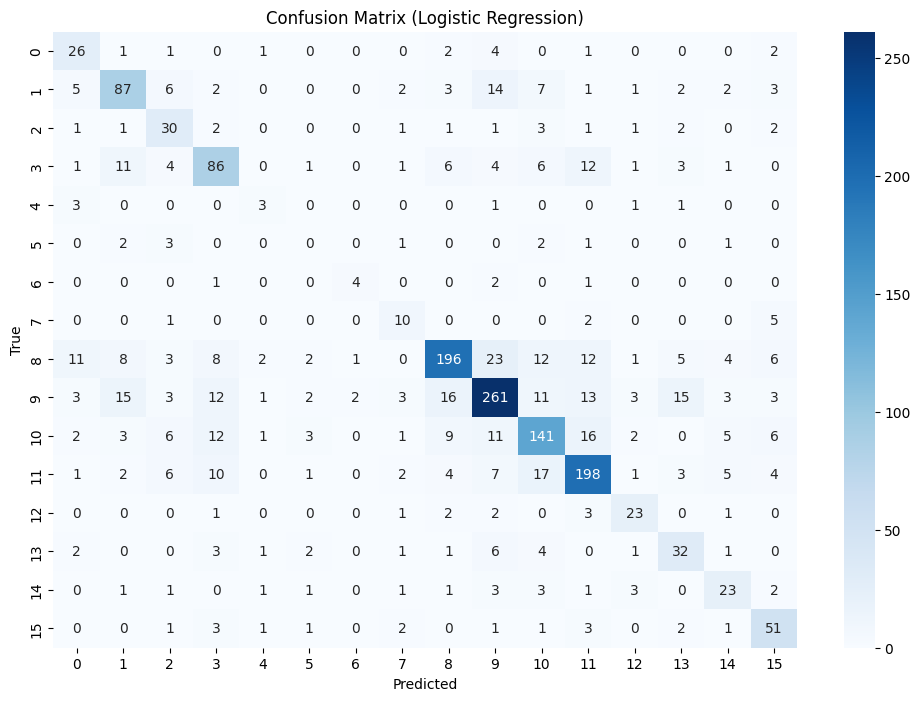

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Logistic Regression)")
plt.show()

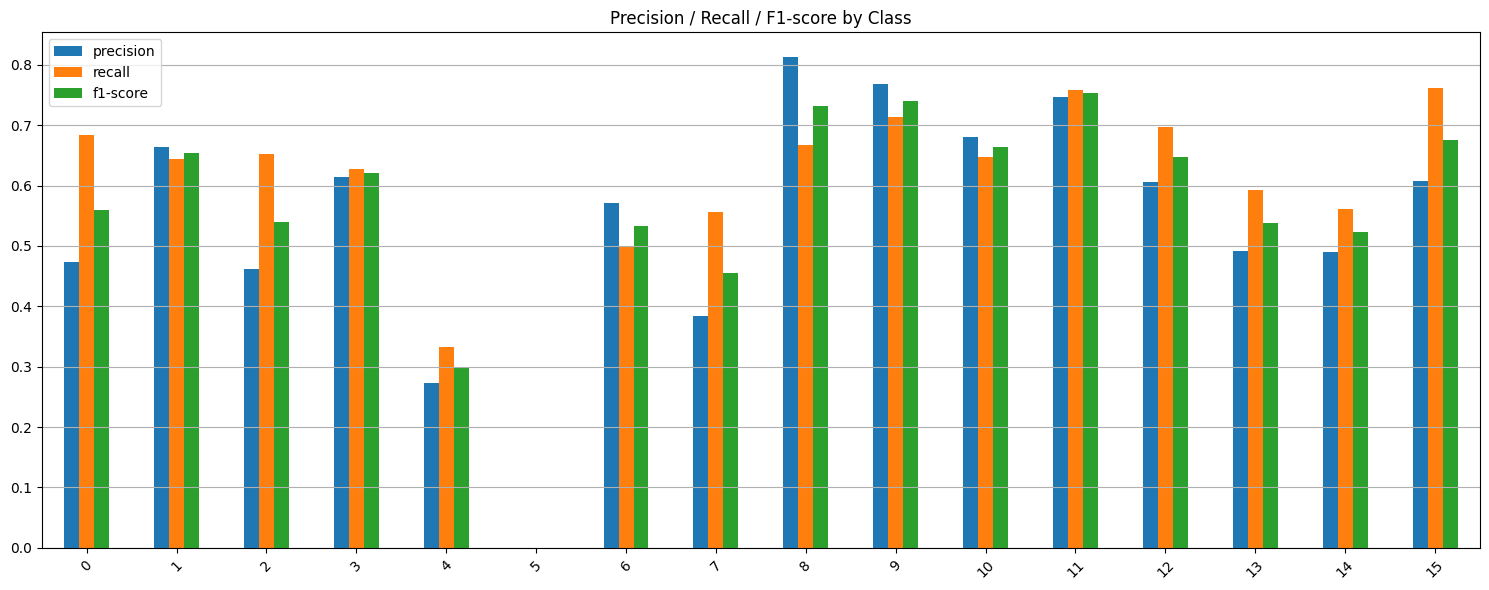

In [20]:
import pandas as pd
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred_lr, output_dict=True)
df_report = pd.DataFrame(report).transpose()

df_report[['precision', 'recall', 'f1-score']].iloc[:-3].plot(
    kind='bar', figsize=(15, 6), title="Precision / Recall / F1-score by Class"
)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()